In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pylightcurve as plc
import numpy as np


###############################################################################################
##### Create a Planet object
###############################################################################################

# At first we need to  create a Planet object.
# Planets include in the ExoClock project (https://www.exoclock.space/database/planets)
# can be loaded automatically. 
# Alteranatively we can difine our custom Planet object (see notebook: The Planet class)

planet = plc.get_planet('HD189733b')

###############################################################################################


exoclock: Checking ephemerides database...
exoclock: Checking catalogues database...
exoclock: Checking ut database...
pylightcurve: Checking exotethys database...
pylightcurve: Checking photometry database...


<IPython.core.display.Javascript object>


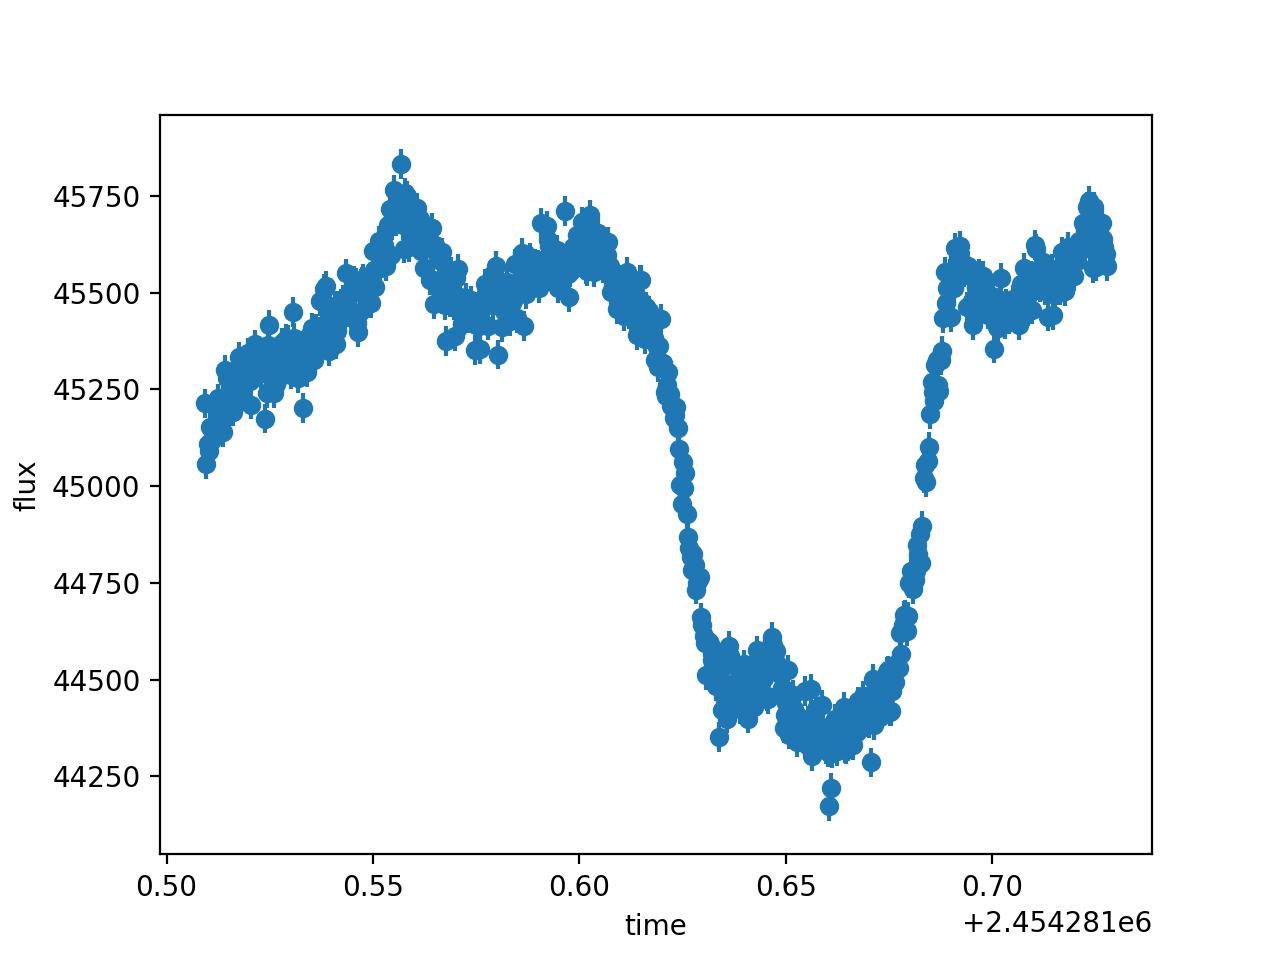

Auxiliary data available:


<IPython.core.display.Javascript object>


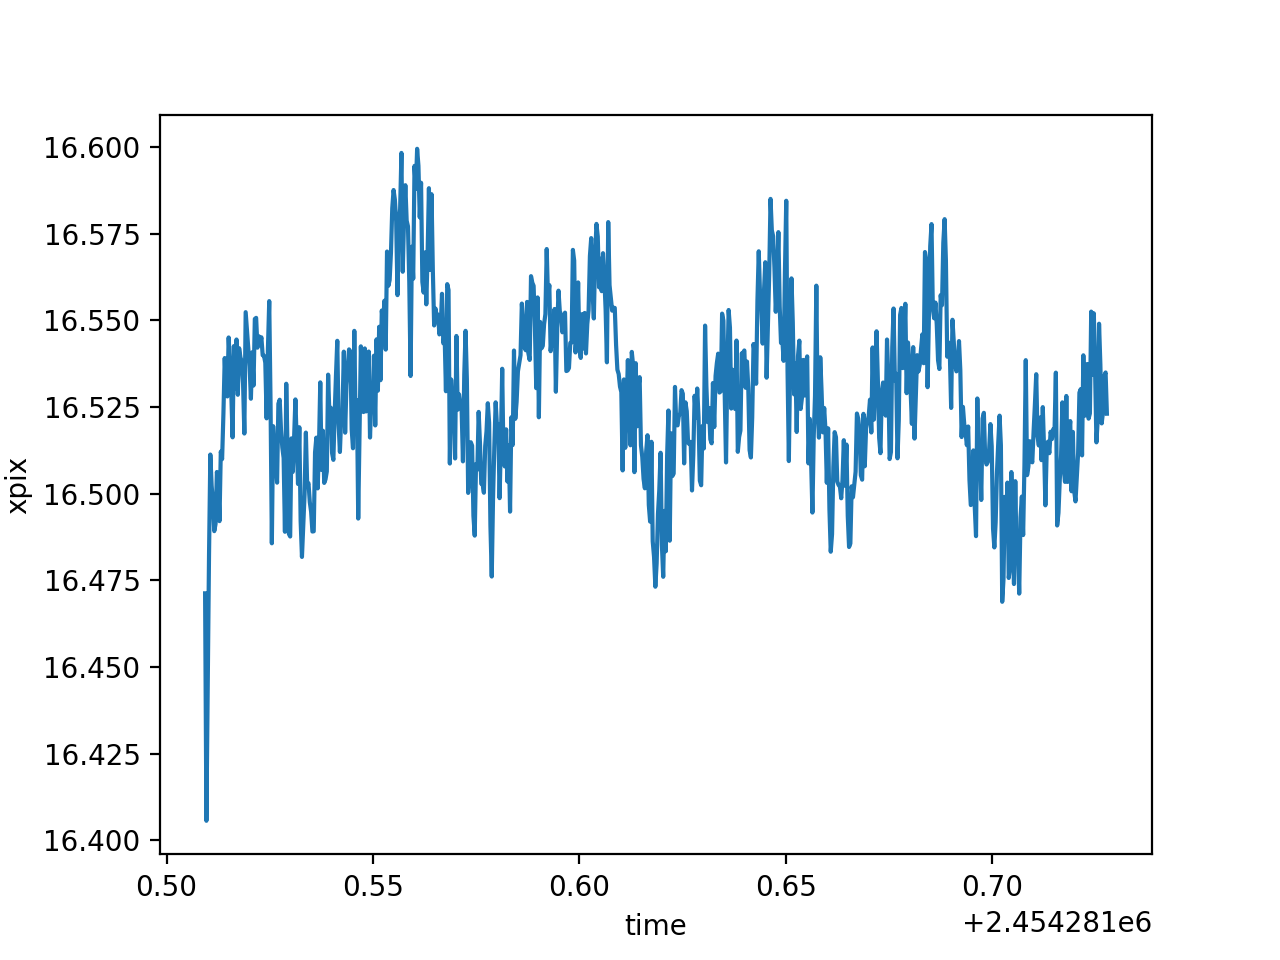

<IPython.core.display.Javascript object>


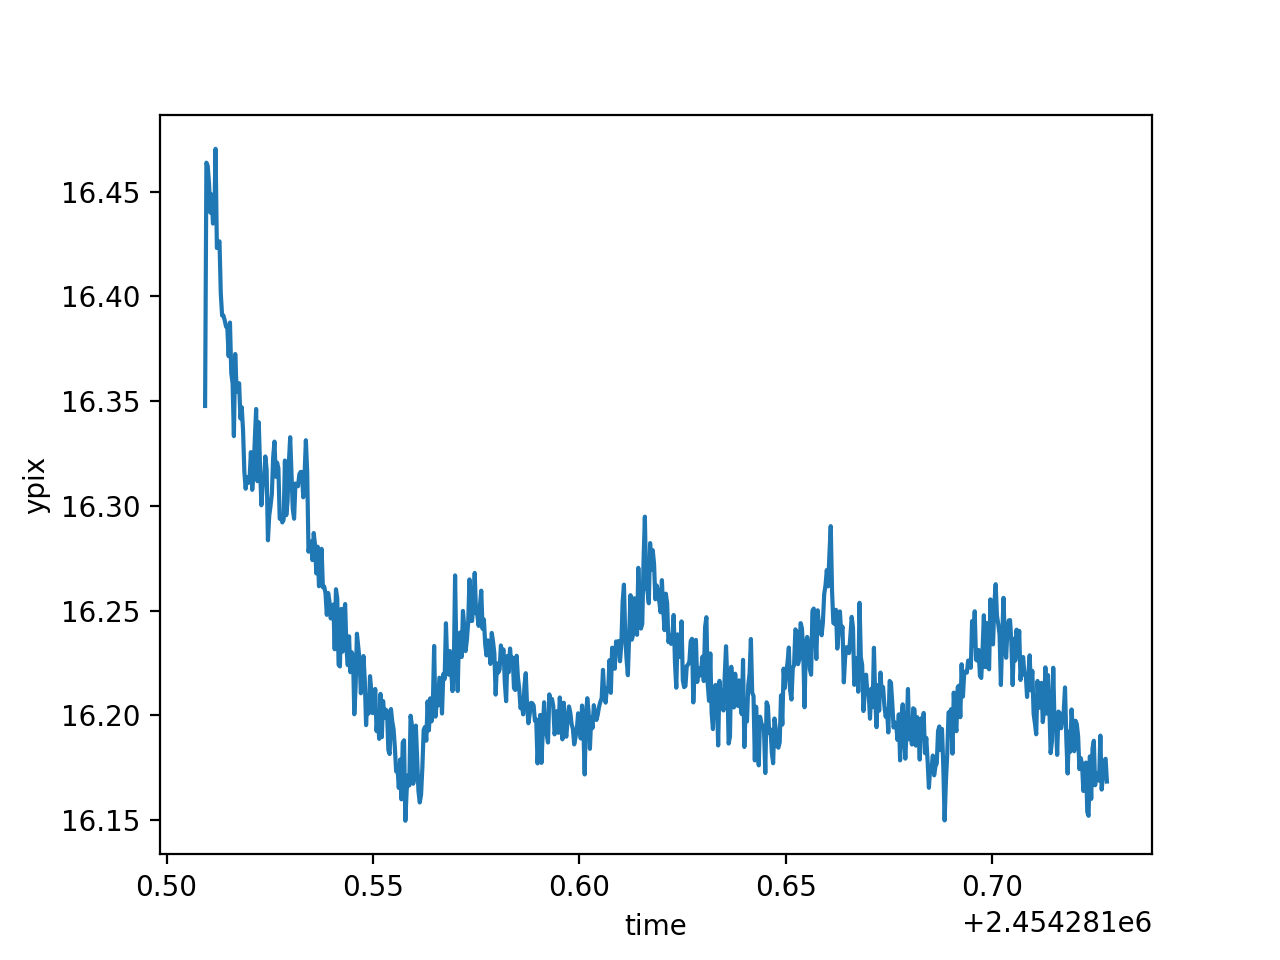

time_format: BJD_UTC
time_stamp: start
exp_time: 0.32
flux_format: flux
filter_name: irac4


In [2]:
###############################################################################################
##### Load data
###############################################################################################

# This dataset contains one transit observation of WASP-39b, obtained by SPITZER/IRAC/CH4

data = plc.open_dict('hd189733b_sst.pickle')

###############################################################################################





###############################################################################################
##### Inspect data
###############################################################################################

# The dictionaly contains the necessary keywords:
# 'time'
# 'time_format'
# 'time_stamp'
# 'exp_time'
# 'flux'
# 'flux_unc'
# 'flux_format'
# 'filter_name'

# In addition, the dictionaly contains as auxiliary data the star position on the detector:
# 'xpix'
# 'ypix'

plt.figure()
plt.ylabel('flux')
plt.xlabel('time')
plt.errorbar(data['time'], data['flux'], data['flux_unc'], fmt='o')

if 'auxiliary_data' in data and data['auxiliary_data']:
    print('Auxiliary data available:')
    for i in data['auxiliary_data']:
        plt.figure()
        plt.ylabel(i)
        plt.xlabel('time')
        plt.plot(data['time'], data['auxiliary_data'][i])

for i in ['time_format', 'time_stamp', 'exp_time', 'flux_format', 'filter_name']:
    print('{0}: {1}'.format(i, data[i]))
    
###############################################################################################





###############################################################################################
##### Define the trend function
###############################################################################################

# By default, the detrending is done using a second order polynomial with time.
# For SPITZER, this trend function is not sufficient.
# Here, we will use a second order polynomial with x and y position.

data['detrending_series'] = ['xpix', 'ypix']
data['detrending_order'] = 2

###############################################################################################





###############################################################################################
##### Define the stellar model
###############################################################################################

# The default stellar model used to calculate the limb-darkening coefficients 
# is the 'Pheonix_2018'. However, there are cases where the filter used for the observation is 
# outside the wavelegth region covered by these specific stellar models, like this dataset.
# Here we will use a different strellar model: 

data['stellar_model'] = 'Atlas_2000'

###############################################################################################





###############################################################################################
##### Add observation to the Planet object
###############################################################################################

# Then we are going to add the observation to the Planet object.
# It is advised to use planet.clear_observations() before, 
# to avoid duplications, in case we forget that we have already added the same observation.

planet.clear_observations()
planet.add_observation_from_dict(data)

###############################################################################################




File already here...  teff05000_logg4.5_MH-0.1.pickle
File already here...  teff05000_logg4.5_MH0.0.pickle
File already here...  teff05000_logg5.0_MH-0.1.pickle
File already here...  teff05000_logg5.0_MH0.0.pickle
File already here...  teff05250_logg4.5_MH-0.1.pickle
File already here...  teff05250_logg4.5_MH0.0.pickle
File already here...  teff05250_logg5.0_MH-0.1.pickle
File already here...  teff05250_logg5.0_MH0.0.pickle

Observation:  obs0
Filter:  irac4
Epoch:  -862
Data-points excluded:  0
Scaling uncertainties by:  1

Optimising initial parameters...
Transit fitting...


<IPython.core.display.Javascript object>


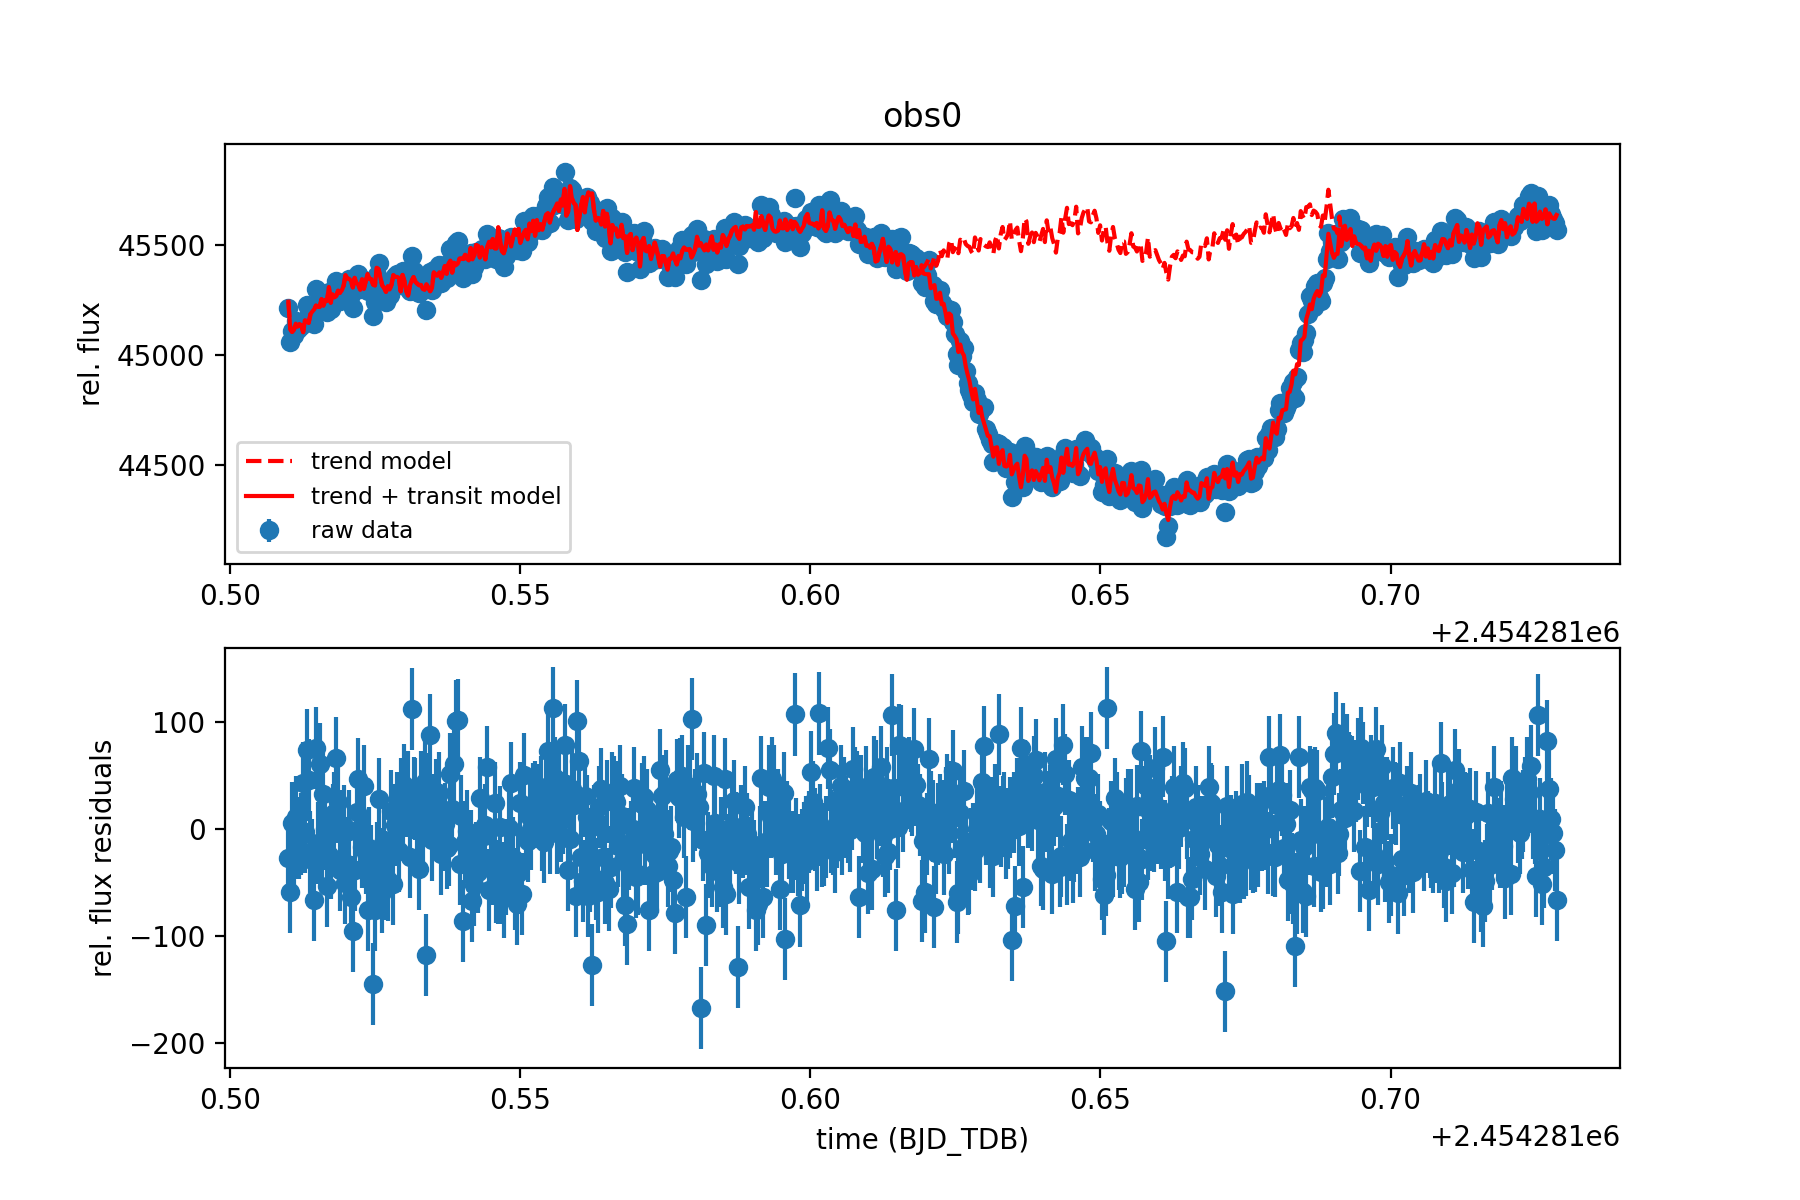


Observation:  obs0
Filter:  irac4
Epoch:  -862
Number of outliers removed:  0
Uncertainties scale factor:  1
Residuals statistics:
res_max_autocorr: 	 0.17432337219829974
res_max_autocorr_flag: 	 True
res_shapiro: 		 0.9930962324142456
res_shapiro_flag: 	 True
res_mean: 		 0.03794841466875843
res_std: 		 41.434208957286316
res_rms: 		 41.43422633522003
res_chi_sqr: 		 808.1586364352573
res_red_chi_sqr: 	 1.1712444006308078


In [3]:

###############################################################################################
##### Test the performance of the trend function 
###############################################################################################

# We can test the performance of the trend function with quick fit, using: 
# optimiser = 'curve_fit'.
# Here, the quality of the data is good enough to fit for the orbital parameters (sma and i):
# fit_sma_over_rs = True
# fit_inclination = True.

test = planet.transit_fitting(
    optimiser = 'curve_fit',
    fit_sma_over_rs=True, 
    fit_inclination=True,
)

###############################################################################################





###############################################################################################
##### Evaluate test results
###############################################################################################

# To evaluate the test results we can plot the raw data, trend function, and residuals like this:

observations = len(test['observations'])
plt.figure(figsize=(9,6))
for obs_n, obs_id in enumerate(test['observations']):
    observation = test['observations'][obs_id]
    plt.subplot(2, observations, obs_n + 1)
    plt.errorbar(observation['input_series']['time'], 
                 observation['input_series']['flux'], 
                 observation['input_series']['flux_unc'], 
                 fmt='o', zorder=0, label='raw data')
    plt.plot(observation['input_series']['time'], observation['output_series']['trend'], 'r--', zorder=1, 
             label='trend model')
    plt.plot(observation['input_series']['time'], observation['output_series']['model'], 'r-', zorder=1,
             label='trend + transit model'
            )
    plt.legend(fontsize='small')
    plt.ylabel('rel. flux')
    plt.title(obs_id)

    plt.subplot(2, observations, observations + 1)
    plt.errorbar(observation['input_series']['time'], 
                 observation['output_series']['residuals'], 
                 observation['input_series']['flux_unc'], 
                 fmt='o', zorder=0)
    plt.xlabel('time (BJD_TDB)')
    plt.ylabel('rel. flux residuals')

    
    
# And also print the residuals diagnostics like this:

for obs_n, obs_id in enumerate(test['observations']):
    observation = test['observations'][obs_id]
    print('')
    print('Observation: ', obs_id)
    print('Filter: ', observation['model_info']['filter_id'])
    print('Epoch: ', observation['model_info']['epoch'])
    print('Number of outliers removed: ', observation['data_conversion_info']['outliers'])
    print('Uncertainties scale factor: ', observation['data_conversion_info']['scale_factor'])

    print('Residuals statistics:')
    print('res_max_autocorr:', '\t', observation['statistics']['res_max_autocorr'])
    print('res_max_autocorr_flag:', '\t', observation['statistics']['res_max_autocorr_flag'])
    print('res_shapiro:', '\t\t', observation['statistics']['res_shapiro'])
    print('res_shapiro_flag:', '\t', observation['statistics']['res_shapiro_flag'])
    print('res_mean:', '\t\t', observation['statistics']['res_mean'])
    print('res_std:', '\t\t', observation['statistics']['res_std'])
    print('res_rms:', '\t\t', observation['statistics']['res_rms'])
    print('res_chi_sqr:', '\t\t', observation['statistics']['res_chi_sqr'])
    print('res_red_chi_sqr:', '\t', observation['statistics']['res_red_chi_sqr'])
    
###############################################################################################


In [4]:

###############################################################################################
##### MCMC fit
###############################################################################################

# If the residuals diagniostics look ok, we can run the MCMC.
# Here we will define the 'output_folder', so that all the results and plots are saved.
# We don't need to defile the optimiser, as the default one is 'mcmc'.
# It is also better to use filter_outliers=True to clear the outliers and 
# and scale_uncertainties=True to scale the errorbars to match the residuals rms.

final = planet.transit_fitting(
    output_folder = 'hd189733b_sst',
    fit_sma_over_rs=True, 
    fit_inclination=True,
    filter_outliers=True,
    scale_uncertainties=True,
)

# By default, the number of iterations is 5000 and the burn in is 1000.
# If the chains do not converge, we can increase these number, for example by setting:
# iterations = 10000
# burn_in = 5000

###############################################################################################



Observation:  obs0
Filter:  irac4
Epoch:  -862
Data-points excluded:  6
Scaling uncertainties by:  1.0303924632984718

Optimising initial parameters...
Transit fitting: 5000 / 5000 , time left: 0:00:00, time elapsed: 0:03:54, total time: 0:03:54
